# Training a FFNN on the Venus dataset with tensorflow

In [2]:
import os
import kagglehub

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from utils import format_param_grid

from joblib import dump, load


/Users/sophusbredesengullbekk/miniconda3/envs/fys_stk/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the data from kaggle
path = kagglehub.dataset_download("fmena14/volcanoesvenus")
files = os.listdir(path)
train_dir = os.path.join(path, 'volcanoes_train')
test_dir = os.path.join(path, 'volcanoes_test')
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# Load sample data from training images and labels
train_images_path = os.path.join(train_dir, 'train_images.csv')
train_labels_path = os.path.join(train_dir, 'train_labels.csv')

train_images = pd.read_csv(train_images_path, header=None)
train_labels = pd.read_csv(train_labels_path)

# Load test data and labels
test_images_path = os.path.join(test_dir, 'test_images.csv')
test_labels_path = os.path.join(test_dir, 'test_labels.csv')

test_images = pd.read_csv(test_images_path, header=None)
test_labels = pd.read_csv(test_labels_path)


In [4]:
# Create a small data subset for testing
train_images = train_images/255
train_labels = train_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels['Volcano?'], test_size=0.2, random_state=42)


In [10]:
# Perform a grid search over the learning rate and regularization parameter for the MLPClassifier

hidden_layers = [(16, 4), (32, 4), (64, 4), (16, 8), (32, 8), (64, 8), (16, 16), (32, 16), (64, 16), (16, 32), (32, 32), (64, 32)]
# hidden_layers = [(16, 4), (32, 4)]
parameters = {
    'hidden_layer_sizes': hidden_layers,
}

model = MLPClassifier(max_iter=500, 
                      random_state=42, 
                      early_stopping=True, 
                      solver='adam',
                      tol=1e-5)

grid_search = GridSearchCV(model, parameters, cv=5, verbose=4)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.score(X_test, y_test))
dump(grid_search, '../grid_search_data/' + format_param_grid(grid_search.param_grid) + '.joblib')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ........hidden_layer_sizes=(16, 4);, score=0.856 total time=  25.5s
[CV 2/5] END ........hidden_layer_sizes=(16, 4);, score=0.856 total time=  10.4s
[CV 3/5] END ........hidden_layer_sizes=(16, 4);, score=0.856 total time=   7.7s
[CV 4/5] END ........hidden_layer_sizes=(16, 4);, score=0.856 total time=   8.3s
[CV 5/5] END ........hidden_layer_sizes=(16, 4);, score=0.855 total time=   8.4s
[CV 1/5] END ........hidden_layer_sizes=(32, 4);, score=0.899 total time=  40.0s
[CV 2/5] END ........hidden_layer_sizes=(32, 4);, score=0.907 total time=  35.7s
[CV 3/5] END ........hidden_layer_sizes=(32, 4);, score=0.906 total time=  58.0s
[CV 4/5] END ........hidden_layer_sizes=(32, 4);, score=0.918 total time=  40.2s
[CV 5/5] END ........hidden_layer_sizes=(32, 4);, score=0.914 total time=  38.1s
[CV 1/5] END ........hidden_layer_sizes=(64, 4);, score=0.856 total time=  20.1s
[CV 2/5] END ........hidden_layer_sizes=(64, 4);

['../grid_search_data/hidden_layer_sizes_(16, 4)_(32, 4)_(64, 4)_(16, 8)_(32, 8)_(64, 8)_(16, 16)_(32, 16)_(64, 16)_(16, 32)_(32, 32)_(64, 32).joblib']

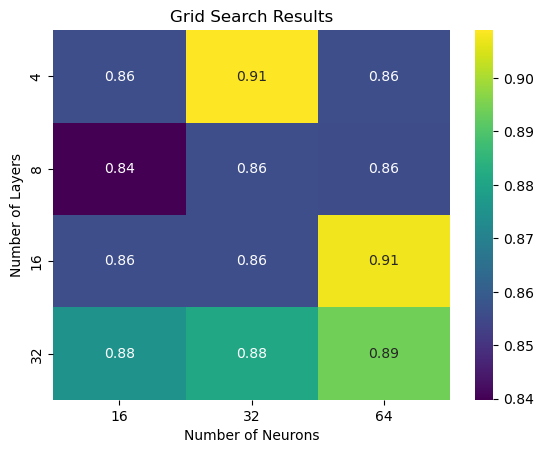

In [11]:
# plot the resulting gridsearch as a heatmap (param_hidden_layer_sizes is a tuple of the hidden layer sizes)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['num_layers'] = results_df['param_hidden_layer_sizes'].apply(lambda x: x[1])
results_df['num_neurons'] = results_df['param_hidden_layer_sizes'].apply(lambda x: x[0])

results_pivot = results_df.pivot(index='num_layers', columns='num_neurons', values='mean_test_score')
sns.heatmap(results_pivot, annot=True, cmap='viridis')
plt.xlabel('Number of Neurons')
plt.ylabel('Number of Layers')
plt.title('Grid Search Results')
plt.show()



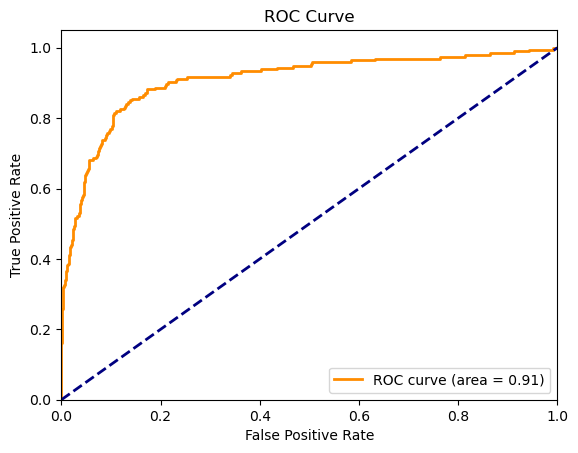

In [13]:
from sklearn.metrics import roc_curve, auc
# Create a ROC curve for the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test)
y_pred = y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()